<a href="https://colab.research.google.com/github/VenkteshV/Question_duplicate_detection/blob/main/BERT_Scores_Part_2NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import torch
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
nltk.download("")

[nltk_data] Error loading : Package '' not found in index


False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df = pd.read_csv("drive/MyDrive/Extramarks Project/Dataset versions/QQD-with-bert-scores.csv")

##### Below is a histogram of the bert-score f1 scores for duplicate an non-duplicate questions. The line in the middle is the median of the f1-scores

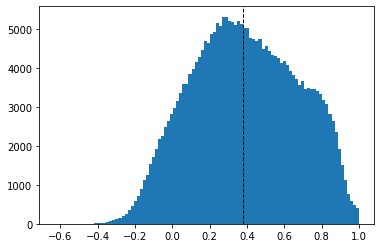

In [ ]:
plt.hist(df[df['is_duplicate'] == 0]['bert-scores-precision'], bins = 100)
plt.axvline(df[df['is_duplicate'] == 0]['bert-scores-precision'].median(), color='k', linestyle='dashed', linewidth=1)
plt.show()

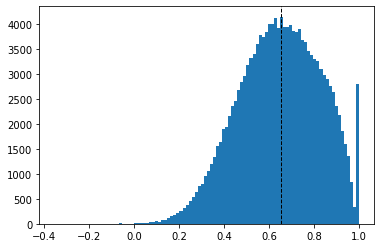

In [ ]:
plt.hist(df[df['is_duplicate'] == 1]['bert-scores-precision'], bins = 100)
plt.axvline(df[df['is_duplicate'] == 1]['bert-scores-precision'].median(), color='k', linestyle='dashed', linewidth=1)
plt.show()

#####Let us assume a Gaussian distribution

In [ ]:
df[df['is_duplicate'] == 0]['bert-scores-precision'].mean()

0.38920957694299707

In [ ]:
df[df['is_duplicate'] == 1]['bert-scores-precision'].mean()

0.6477361867853332

In [ ]:
df[df['is_duplicate'] == 0]['bert-scores-precision'].std()

0.28220244196692706

In [ ]:
df[df['is_duplicate'] == 1]['bert-scores-precision'].std()

0.18046346677964378

By the 68–95–99.7 rule

From the above information we can see that the f1-scores for 68% of the non-duplicates would lie between (0.1; 0.66).

From the above information we can see that 68% of the duplicates would lie between (0.47;0.83)


##### Let us now more closely examine what are the sentence that have high similarit in BERT Scores but still are not duplicates. 

In [ ]:
highBert = df.loc[(df['bert-scores-f1'] > 0.7) & (df['is_duplicate'] == 0)][['qid1', 'qid2','question1','question2','bert-scores-f1','is_duplicate']]

In [ ]:
highBert.sample(10)

,qid1,qid2,question1,question2,bert-scores-f1,is_duplicate
34359,62990,62991,what are best aspects of living in niigata jap...,what are best aspects of living in joetsu niig...,0.896304,0
127157,80749,68499,how can we treat high blood pressure,how do i treat low blood pressure,0.814153,0
359056,488821,488822,how is iimb better,why is iimb better iima,0.791601,0
171517,38097,265107,how can apps make money without advertisement,how do website online games make money without...,0.796744,0
58816,103156,103157,what are some major landforms in texas how do ...,what are some major landforms in texas how do ...,0.906541,0
206250,309720,309721,why don t girls reply on okcupid,how come that girls doesn t reply when you mes...,0.728829,0
369131,499708,170264,where can i hire very experienced plastering c...,where can i hire very efficient commercial res...,0.890794,0
398475,477090,374416,why does michigan believe in not invoking deat...,why does wisconsin believe in not invoking dea...,0.886626,0
397916,29241,531279,what colors go well with green,what colors go best with dark green,0.880748,0
107733,177233,177234,what is kilowatt hour,how much is kilowatt hour per month,0.753116,0


##### Similarly, let us now more closely examine what are the sentence that are identified as duplicate even though they have low BERT Score

In [ ]:
lowBert = df.loc[(df['bert-scores-f1'] < 0.4) & (df['is_duplicate'] == 1)][['qid1', 'qid2','question1','question2','bert-scores-f1','is_duplicate']]

In [ ]:
lowBert.sample(10)

,qid1,qid2,question1,question2,bert-scores-f1,is_duplicate
183351,48870,150726,what are foods that reduce tummy fat,how can i reduce my hips tummy in less week,0.366660,1
69617,106701,72184,would mr donald trump be better president hill...,how is hillary clinton better donald trump,0.399846,1
349217,382114,318043,when light falls on object it absorbs some col...,when light gets absorbed into material where d...,0.264167,1
168238,260749,13737,what is best app to track someone s phone loca...,how can i locate my husband s phone location w...,0.389128,1
204322,1375,4040,what would be effect of 500 1000 rs notes ban,why narendra modi banned 500 1000 notes in India,0.379920,1
360362,294014,170583,what are good ways to prepare for gate exam in...,how should gate be cracked within 3 months ece,0.190948,1
274290,60339,67971,did India do surgical strikes inside pok,has India provided any proof of surgical strike,0.303484,1
242727,28639,22873,why do people use Quora instead of google to f...,why should we use Quora when we can google eve...,0.363528,1
5248,10335,10336,apart from usual social networking websites wh...,what are best websites to visit everyday,0.284428,1
33330,34003,61275,is best question you ve read on Quora,what are best questioned asked in Quora,0.220717,1


##### Let us see at what points does the probability of a sentence being a duplicate becomes more than that of a non-duplicate
1. Take intervals of 0.02 in bert scores and count the number of suplicates and non-duplicated in the interval.
2. Store the percentage of duplicates in each interval.

In [ ]:
print("Duplicates: ", len(df[df['is_duplicate'] == 1]))
print("Non-duplicates: ", len(df[df['is_duplicate'] == 0]))

Duplicates:  149253
Non-duplicates:  254875


In [ ]:
sortedDf = df.sort_values("bert-scores-f1")
sortedDf.head(3)

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,len1,len2,bert-scores-precision,bert-scores-recall,bert-scores-f1
59599,59614,59624,59624,104400,104401,maduvvary school ge haalathu ehaaraai mihaaru,wave with long wavelength has relatively,0,46,47,-0.587279,-0.300005,-0.845627
222308,222359,222404,222404,329954,329955,siapa sajakah yang boleh mengikuti gerakan nas...,what effects do cloves have on pregnancy,0,73,43,-0.480838,-0.127066,-0.790327
144699,144735,144760,144760,229018,229019,ionophore is universal vancomycin ionomycin or...,about what year were japanese universities fir...,0,67,80,-0.498449,-0.219139,-0.750894


Since the BERT Scorees are normalized to be in the range of 0-100 (most of them), we can ignore the very small values like 0.8 or 0.6 => we will start the analysis from the values -0.3  

In [ ]:
df_index = 0
intervalRatios = []
intervals = []
for i in range(-40,100,2):
  lr = i/100
  hr = (i+2)/100
  start_index = df_index
  partOfDf = df.loc[(df['bert-scores-f1'] > lr) & (df['bert-scores-f1'] < hr)]
  intervals.append(partOfDf)
  if(len(partOfDf)==0):
    ratioOfDuplicates = 0
    print("No df in range ", lr," - ", hr) 
  else:
    ratioOfDuplicates = len(partOfDf[partOfDf['is_duplicate'] == 1]) / len(partOfDf)
  
  intervalRatios.append(ratioOfDuplicates) 


intervalPercentagesDupl = [x*100 for x in intervalRatios]
intervalPercentagesNonDupl = [100 - (x*100) for x in intervalRatios]
ranges = np.arange(-0.4,1,0.02)

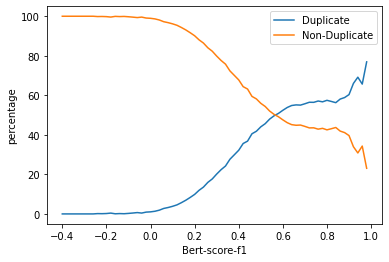

The point where the lines intersect is:  [0.56]  - bert-score-f1


In [ ]:
plt.plot(ranges, intervalPercentagesDupl, label='Duplicate')
plt.plot(ranges, intervalPercentagesNonDupl, label='Non-Duplicate')
plt.xlabel("Bert-score-f1")
plt.ylabel("percentage")
idx = np.argwhere(np.diff(np.sign(np.array(intervalPercentagesDupl) - np.array(intervalPercentagesNonDupl)))).flatten()
plt.legend()
plt.show()
print("The point where the lines intersect is: ", ranges[idx], " - bert-score-f1")

##### The point where the lines intersect is:  [0.56]  - bert-score-f1. 
##### Let us now get the clean data for the test datase and apply a strong threshold to see the results

In [ ]:
!pip install evaluate
!pip install bert_score

import nltk

from nltk.corpus import stopwords
from evaluate import load
from time import time
nltk.download("")

In [ ]:
testDf = pd.read_csv("drive/MyDrive/Extramarks Project/Dataset versions/QQD-test-data-cleaner-less.csv")

In [ ]:
testDf = testDf.dropna()
testDf = testDf[testDf['question2'].str.len() >= 10]
testDf = testDf[testDf['question1'].str.len() >= 10]

In [ ]:
for i in df['question1']:
  if type(i) != type("") or len(i) <= 7 :
    print(i)

In [ ]:
bertscore = load("bertscore")

In [ ]:
print(len(testDf)/40000)

87.99685


In [ ]:
resultFinalF1= []
resultFinalRecall= []
resultFinalPrecision= []

for i in range(0, 87):
  print("Round", i+1,"/87")
  t =time()
  predictions1 = list(testDf[40000*i:40000*(i+1)]['question1'])
  references1 = list(testDf[40000*i:40000*(i+1)]['question2'])
  results1 = bertscore.compute(predictions=predictions1, references=references1, lang="en", rescale_with_baseline=True, verbose = True)

  resultFinalF1 = resultFinalF1 + results1['f1']
  resultFinalRecall = resultFinalRecall + results1['recall']
  resultFinalPrecision = resultFinalPrecision + results1['precision']

  print("Time taken: " , int((time() - t)%60) ,"s, ", int((time() - t)/60), "m")
  print()

Round 1 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1243 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -36513.45 seconds, -1.10 sentences/sec
Time taken:  58 s,  3 m

Round 2 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1244 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -36279.86 seconds, -1.10 sentences/sec
Time taken:  53 s,  3 m

Round 3 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1244 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -36046.21 seconds, -1.11 sentences/sec
Time taken:  53 s,  3 m

Round 4 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1244 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -35812.49 seconds, -1.12 sentences/sec
Time taken:  53 s,  3 m

Round 5 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1243 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -35577.04 seconds, -1.12 sentences/sec
Time taken:  55 s,  3 m

Round 6 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1244 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -35343.00 seconds, -1.13 sentences/sec
Time taken:  54 s,  3 m

Round 7 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1243 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -35108.72 seconds, -1.14 sentences/sec
Time taken:  54 s,  3 m

Round 8 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1243 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/625 [00:00<?, ?it/s]

done in -34875.13 seconds, -1.15 sentences/sec
Time taken:  53 s,  3 m

Round 9 /87
calculating scores...
computing bert embedding.


  0%|          | 0/1243 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
t =time()
predictions1 = list(testDf[3480000:]['question1'])
references1 = list(testDf[3480000:]['question2'])
results1 = bertscore.compute(predictions=predictions1, references=references1, lang="en", rescale_with_baseline=True, verbose = True)

resultFinalF1 = resultFinalF1 + results1['f1']
resultFinalRecall = resultFinalRecall + results1['recall']
resultFinalPrecision = resultFinalPrecision + results1['precision']

print("Time taken: " , int((time() - t)%60) ,"s, ", int((time() - t)/60), "m")

In [ ]:
testDf['bert-scores-precision'] = resultFinalF1
testDf['bert-scores-recall'] = resultFinalRecall
testDf['bert-scores-f1'] = resultFinalPrecision

In [ ]:
df.to_csv("drive/MyDrive/Extramarks Project/Dataset versions/QQD-test-data-cleaner-less-with-BERT-Scores.csv")